In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from utils_io import get_imaging_files
from utils_image import UnrotateCropFrame, RegFrame, hist_match, getMeanTiff_equalsampling
from scanimagetiffio import SITiffIO  

In [2]:
def convertto255(img):
    img = img.astype(np.float32)
    #normalize to 0-1 according to min max
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    img = img*255
    img = img.astype(np.uint8)
    return img

## 1, read tiff files

In [3]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"

still_length = 50

filenamelist = ["00005"]


#get file triples, including Tiff file, VR logs and RE logs
allfiles = get_imaging_files(datafolder, filenamelist, readVRlogs=True)

tifffile, relogfile, vrlogfile  = allfiles[0]
print ('processing: \n' + tifffile.split('/')[-1] + '\n' + relogfile.split('/')[-1] + '\n' + vrlogfile.split('/')[-1]+'...')

S = SITiffIO()
S.open_tiff_file(tifffile, "r")
S.open_rotary_file(relogfile)
S.open_log_file(vrlogfile)
S.interp_times()  # might take a while...

#get still intervals
time =S.get_tiff_times()
theta = S.get_all_theta()
#to array
theta = np.array(theta)



processing: 
03082023_00005.tif
REdata_20230803_174303.00005.txt
20230803-174351.51.00005.txt...
Loading rotary encoder file: /media/zilong/4TB Storage HDD/2PImaging/183_03082023/REdata_20230803_174303.00005.txt
Calculating rotations and times from rotary encoder data...
Finished calculating rotations and times.
The rotary encoder file has 35859 timestamps in it.

Loading log file: /media/zilong/4TB Storage HDD/2PImaging/183_03082023/20230803-174351.51.00005.txt
Calculating rotations and times from log file data...
Finished calculating rotations and times.
The log file file has 15502 timestamps in it.
Counted 9000 frames


## 2, plot image registration procedure

### 2-1, get the raw mean images from the tiff file

In [5]:
#get the raw mean images from the tiff file
avgImg_raw = getMeanTiff_equalsampling(S, numBins=72)

### 2-2, registrating selected images

In [5]:
N = 3000
frames = []
for i in range(1, N+1):
    frames.append(S.get_frame(i))
#convert to numpy array
frames = np.array(frames)
thetas = S.get_all_theta()[:N]

#read the detected center
circlecenterfilename = os.path.join(datafolder, "DP_exp", "circlecenter.txt")
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])
    
unrotframes = UnrotateCropFrame(frames, thetas, rotCenter=[rotx, roty])

#get the average image from the unrotated frames
avgImg_unrot = np.mean(unrotframes, axis=0)

#register the unrotated frames
avgImg_reg, regframes = RegFrame(unrotframes)

Reference frame, 4.46 sec.
Registered 200/3000 in 1.78s
Registered 400/3000 in 3.61s
Registered 600/3000 in 5.40s
Registered 800/3000 in 7.22s
Registered 1000/3000 in 9.01s
Registered 1200/3000 in 10.82s
Registered 1400/3000 in 12.72s
Registered 1600/3000 in 14.61s
Registered 1800/3000 in 16.36s
Registered 2000/3000 in 18.12s
Registered 2200/3000 in 19.91s
Registered 2400/3000 in 21.68s
Registered 2600/3000 in 23.44s
Registered 2800/3000 in 25.20s
Registered 3000/3000 in 26.92s


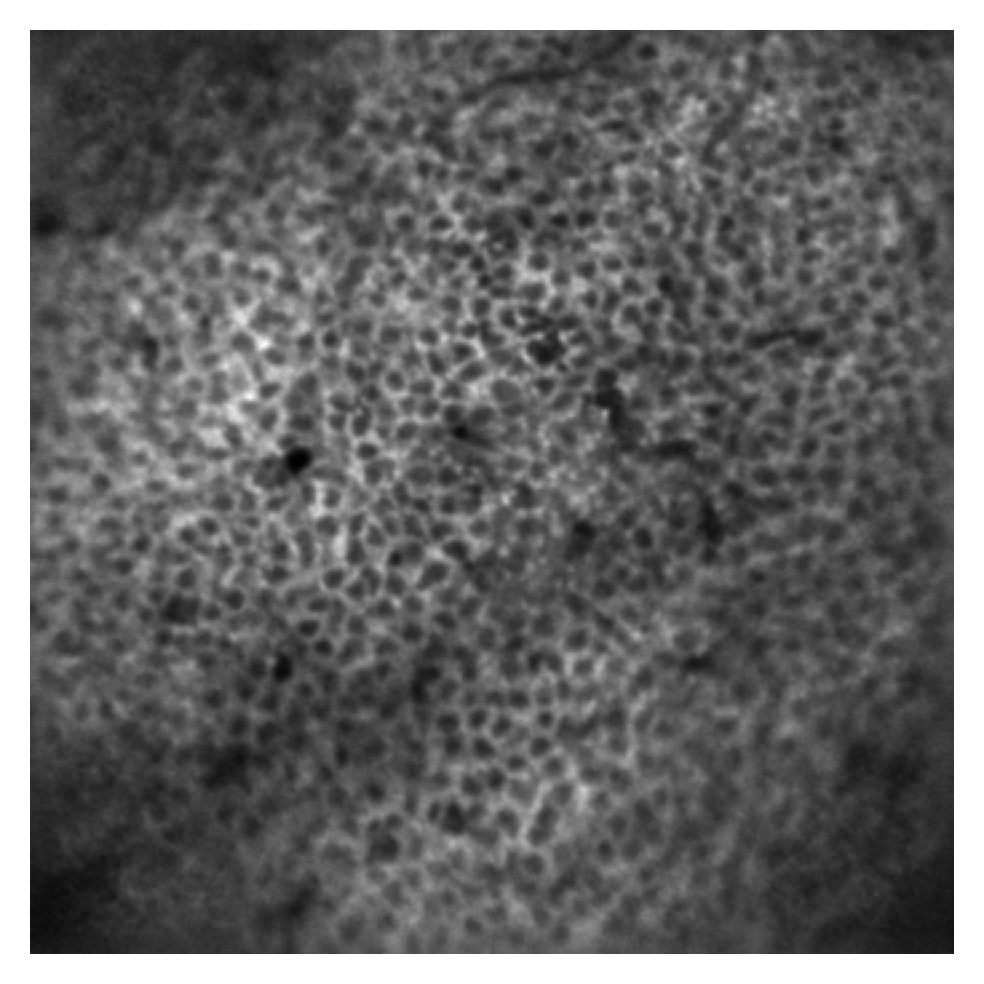

In [7]:
#plot the mean image

fig = plt.figure(figsize=(4,4), dpi=300)

labelsize = 10
ticksize = 8
plt.imshow(avgImg_reg, cmap='gray')
plt.axis('off')
plt.savefig("../Figures/Figure2_meanImg.pdf", dpi=300, bbox_inches='tight')

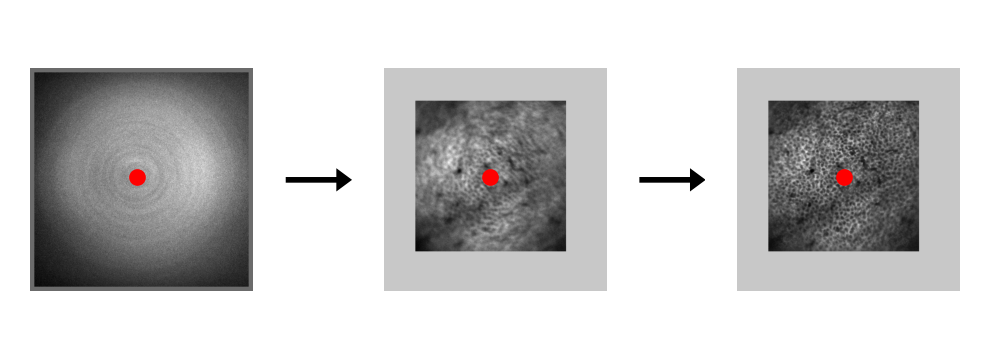

In [32]:
#imshow the averaged image
fig = plt.figure(figsize=(4,1.3), dpi=300)

labelsize = 10
ticksize = 8
gs = GridSpec(1, 5, width_ratios=[1,0.3,1,0.3,1])

#plot aveImg_raw
avgImg_raw = convertto255(avgImg_raw)
ax0 = fig.add_subplot(gs[0])

ax0.imshow(avgImg_raw, cmap='gray')
ax0.set_xticks([]); ax0.set_yticks([])
ax0.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax0.plot(rotx, roty, 'ro', markersize=3)
#equal axis
# ax0.set_aspect('equal')

#plot aveImg_unrot
#first init and background image as the mean value and  the same size as avgImg_raw, 
#then plot the unrotated image on the background with the image center at [rotx, roty]
avgImg_unrot = convertto255(avgImg_unrot)
bg_img_unrot = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_unrot = bg_img_unrot.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = avgImg_unrot.shape[0]//2
half_w = avgImg_unrot.shape[1]//2
bg_img_unrot[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = avgImg_unrot

# plot a horizontal arrow
ax1 = fig.add_subplot(gs[1])
ax1.arrow(0, 0, 1, 0, head_width=0.01, head_length=0.2, fc='k', ec='k', linewidth=1)
# add text above the arrow to show the step of unrotation
#ax1.text(0.5, 0.12, 'Unrotating', horizontalalignment='center', verticalalignment='bottom', fontsize=ticksize)
ax1.set_ylim(-0.1, 0.1)
#ticks off and axis off
ax1.set_xticks([]); ax1.set_yticks([])
ax1.axis('off')

ax2 = fig.add_subplot(gs[2])

ax2.imshow(bg_img_unrot, cmap='gray')
ax2.set_xticks([]); ax2.set_yticks([])
ax2.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax2.plot(rotx, roty, 'ro', markersize=3)

# plot a horizontal arrow with line width 1
ax3 = fig.add_subplot(gs[3])
ax3.arrow(0, 0, 1, 0, head_width=0.01, head_length=0.2, fc='k', ec='k', linewidth=1)
# add text above the arrow to show the step of unrotation, set font size to ticksize
# ax3.text(0.5, 0.12, 'Registration', horizontalalignment='center', verticalalignment='bottom', fontsize=ticksize)
ax3.set_ylim(-0.1, 0.1)
#ticks off and axis off
ax3.set_xticks([]); ax1.set_yticks([])
ax3.axis('off')

#plot aveImg_reg
##first init and background image as black the same size as avgImg_raw, 
#then plot the reg image on the background with the image center at [rotx, roty]
avgImg_reg = convertto255(avgImg_reg)
bg_img_reg = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_reg = bg_img_reg.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = avgImg_reg.shape[0]//2
half_w = avgImg_reg.shape[1]//2
bg_img_reg[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = avgImg_reg

ax4 = fig.add_subplot(gs[4])

ax4.imshow(bg_img_reg, cmap='gray')
ax4.set_xticks([]); ax4.set_yticks([])
ax4.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax4.plot(rotx, roty, 'ro', markersize=3)

plt.savefig("../Figures/ImageProcessProcedure.pdf", dpi=300, bbox_inches='tight')


## 3, get registration examples

In [6]:
selected_frames = {}
selected_theta = {}

#get index of theta in four intervals, which are 85-95, 175-185, 265-275, 355-5
#first 85-95
theta_85_95 = np.where((theta>=60) & (theta<=120))[0]
theta_175_185 = np.where((theta>=150) & (theta<=210))[0]
theta_265_275 = np.where((theta>=240) & (theta<=300))[0]
theta_355_5 = np.where((theta>=330) | (theta<=30))[0]

#get the number of frames in each interval and store them in a list
num_frames = [len(theta_85_95), len(theta_175_185), len(theta_265_275), len(theta_355_5)]

min_num = min(num_frames)

#get al the frames in each interval and angles
frames_85_95 = []; angles_85_95 = []
for i, ti in enumerate(theta_85_95):
    if i>=min_num:
        break
    frames_85_95.append(S.get_frame(ti+1))
    angles_85_95.append(theta[ti+1])

frames_175_185 = []; angles_175_185 = []
for i, ti in enumerate(theta_175_185):
    if i>=min_num:
        break
    frames_175_185.append(S.get_frame(ti+1))   
    angles_175_185.append(theta[ti+1])
    
frames_265_275 = []; angles_265_275 = []
for i, ti in enumerate(theta_265_275):
    if i>=min_num:
        break
    frames_265_275.append(S.get_frame(ti+1))
    angles_265_275.append(theta[ti+1])
    
frames_355_5 = []; angles_355_5 = []
for i, ti in enumerate(theta_355_5):
    if i>=min_num:
        break
    frames_355_5.append(S.get_frame(ti+1))
    angles_355_5.append(theta[ti+1])
    
#store all the frames and angles in a dictionary
selected_frames['85-95'] = frames_85_95; selected_theta['85-95'] = angles_85_95
selected_frames['175-185'] = frames_175_185; selected_theta['175-185'] = angles_175_185
selected_frames['265-275'] = frames_265_275; selected_theta['265-275'] = angles_265_275
selected_frames['355-5'] = frames_355_5; selected_theta['355-5'] = angles_355_5


### 3-1, registrating images

In [7]:
#concate values in still_frames into an array
selected_frames_array = np.concatenate((np.array(selected_frames['85-95']), np.array(selected_frames['175-185']), np.array(selected_frames['265-275']), np.array(selected_frames['355-5'])), axis=0)
#concate values in still_theta into an array
selected_theta_array = np.concatenate((np.array(selected_theta['85-95']), np.array(selected_theta['175-185']), np.array(selected_theta['265-275']), np.array(selected_theta['355-5'])), axis=0)

#read the detected center
circlecenterfilename = os.path.join(datafolder, "DP_exp", "circlecenter.txt")
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])
    
unrotframes = UnrotateCropFrame(selected_frames_array, selected_theta_array, rotCenter=[rotx, roty])

#register the unrotated frames
avgImg_reg, regframes = RegFrame(unrotframes)

meanref_85_95 = np.mean(regframes[0:min_num], axis=0)
meanref_175_185 = np.mean(regframes[min_num:2*min_num], axis=0)
meanref_265_275 = np.mean(regframes[2*min_num:3*min_num], axis=0)
meanref_355_5 = np.mean(regframes[3*min_num:4*min_num], axis=0)

Reference frame, 4.43 sec.
Registered 200/3840 in 1.72s
Registered 400/3840 in 3.42s
Registered 600/3840 in 5.10s
Registered 800/3840 in 6.69s
Registered 1000/3840 in 8.34s
Registered 1200/3840 in 10.08s
Registered 1400/3840 in 11.62s
Registered 1600/3840 in 13.23s
Registered 1800/3840 in 14.81s
Registered 2000/3840 in 16.37s
Registered 2200/3840 in 17.95s
Registered 2400/3840 in 19.56s
Registered 2600/3840 in 21.11s
Registered 2800/3840 in 22.74s
Registered 3000/3840 in 24.33s
Registered 3200/3840 in 26.08s
Registered 3400/3840 in 27.66s
Registered 3600/3840 in 29.22s
Registered 3800/3840 in 30.86s
Registered 3840/3840 in 31.22s


### 3-2, plot the mean frames along with the registered ones in each direction interval

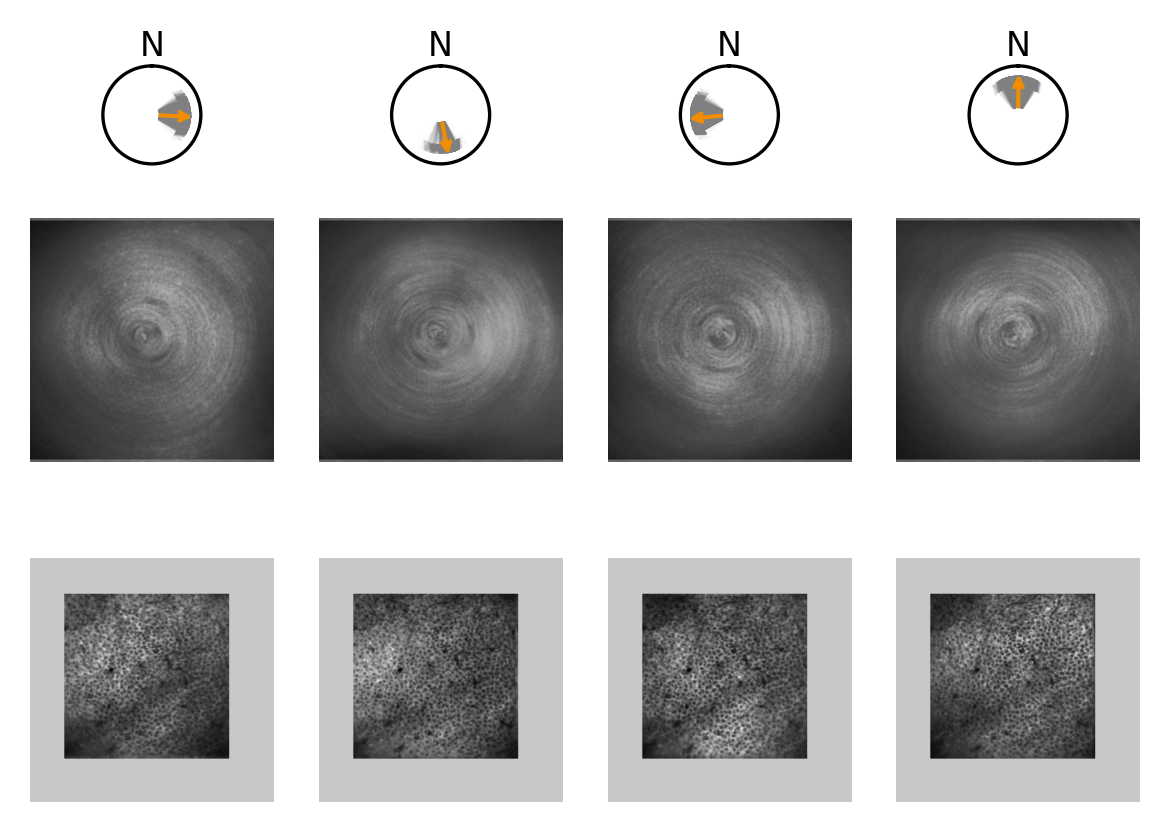

In [10]:
#plot the mean frames in four intervals in a 3*4 grid, with dpi=300
fig = plt.figure(figsize=(4,3), dpi=300)
gs = GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 1], height_ratios=[0.3, 1, 1])
labelsize = 10
ticksize = 8

# Define the arrow properties
arrow_props = dict(arrowstyle='->', lw=1, mutation_scale=5, color='#F18D00')

#plot a pinwheel with a arrow indicating an angle of meanangle1
ax00 = fig.add_subplot(gs[0, 0], projection='polar')
ax00.set_theta_zero_location("N")
ax00.set_theta_direction(-1)
ax00.set_rlim(0, 1)
ax00.set_rticks([])
ax00.set_xticks([])
ax00.set_yticks([])
meanangle1 = np.mean(angles_85_95)/180*np.pi
#annotate all the angles in the interval
for angle in angles_85_95:
    ax00.annotate("", xy=(angle/180*np.pi, 1.0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=0.5, mutation_scale=5, color='gray', alpha=0.1))
ax00.annotate("", xy=(meanangle1, 1.0), xytext=(0, 0), arrowprops=arrow_props)
#ax00.set_xlabel('Angle: '+str(round(meanangle1/np.pi*180, 1))+'°', fontsize=ticksize, labelpad=5)
#mark north as 'N'
ax00.text(0, 1.4, 'N', fontsize=ticksize, horizontalalignment='center', verticalalignment='center')

ax10 = fig.add_subplot(gs[1,0])
meanimg_85_95 = np.mean(frames_85_95, axis=0)
meanimg_85_95 = hist_match(meanimg_85_95, avgImg_reg)
ax10.imshow(meanimg_85_95, cmap='gray')
ax10.axis('off')

ax20 = fig.add_subplot(gs[2,0])
meanref_85_95 = hist_match(meanref_85_95, avgImg_reg)
#convert to 255 and then put the image on the background
meanref_85_95 = convertto255(meanref_85_95)
bg_img_85_95 = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_85_95 = bg_img_85_95.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = meanref_85_95.shape[0]//2
half_w = meanref_85_95.shape[1]//2
bg_img_85_95[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = meanref_85_95
ax20.imshow(bg_img_85_95, cmap='gray')
ax20.axis('off')

ax01 = fig.add_subplot(gs[0, 1], projection='polar')
ax01.set_theta_zero_location("N")
ax01.set_theta_direction(-1)
ax01.set_rlim(0, 1)
ax01.set_rticks([])
ax01.set_xticks([])
ax01.set_yticks([])
meanangle2 = np.mean(angles_175_185)/180*np.pi
#annotate all the angles in the interval
for angle in angles_175_185:
    ax01.annotate("", xy=(angle/180*np.pi, 1.0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=0.5, mutation_scale=5, color='gray', alpha=0.01))
ax01.annotate("", xy=(meanangle2, 1.0), xytext=(0, 0), arrowprops=arrow_props)
#ax01.set_xlabel('Angle: '+str(round(meanangle2/np.pi*180, 1))+'°', fontsize=ticksize, labelpad=5)
#mark north as 'N'
ax01.text(0, 1.4, 'N', fontsize=ticksize, horizontalalignment='center', verticalalignment='center')

ax11 = fig.add_subplot(gs[1,1])
meanimg_175_185 = np.mean(frames_175_185, axis=0)
meanimg_175_185 = hist_match(meanimg_175_185, avgImg_reg)    
ax11.imshow(meanimg_175_185, cmap='gray')
ax11.axis('off')

ax21 = fig.add_subplot(gs[2,1])
meanref_175_185 = hist_match(meanref_175_185, avgImg_reg)   
#convert to 255 and then put the image on the background
meanref_175_185 = convertto255(meanref_175_185)
bg_img_175_185 = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_175_185 = bg_img_175_185.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = meanref_175_185.shape[0]//2
half_w = meanref_175_185.shape[1]//2
bg_img_175_185[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = meanref_175_185
ax21.imshow(bg_img_175_185, cmap='gray')
ax21.axis('off')

ax02 = fig.add_subplot(gs[0, 2], projection='polar')
ax02.set_theta_zero_location("N")
ax02.set_theta_direction(-1)
ax02.set_rlim(0, 1)
ax02.set_rticks([])
ax02.set_xticks([])
ax02.set_yticks([])
meanangle3 = np.mean(angles_265_275)/180*np.pi
#annotate all the angles in the interval
for angle in angles_265_275:
    ax02.annotate("", xy=(angle/180*np.pi, 1.0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=0.5, mutation_scale=5, color='gray', alpha=0.1))
ax02.annotate("", xy=(meanangle3, 1.0), xytext=(0, 0), arrowprops=arrow_props)
#ax02.set_xlabel('Angle: '+str(round(meanangle3/np.pi*180, 1))+'°', fontsize=ticksize, labelpad=5)
#mark north as 'N'
ax02.text(0, 1.4, 'N', fontsize=ticksize, horizontalalignment='center', verticalalignment='center')


ax12 = fig.add_subplot(gs[1,2])
meanimg_265_275 = np.mean(frames_265_275, axis=0)
meanimg_265_275 = hist_match(meanimg_265_275, avgImg_reg)
ax12.imshow(meanimg_265_275, cmap='gray')
ax12.axis('off')

ax22 = fig.add_subplot(gs[2,2])
meanref_265_275 = hist_match(meanref_265_275, avgImg_reg)
#convert to 255 and then put the image on the background
meanref_265_275 = convertto255(meanref_265_275)
bg_img_265_275 = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_265_275 = bg_img_265_275.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = meanref_265_275.shape[0]//2
half_w = meanref_265_275.shape[1]//2
bg_img_265_275[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = meanref_265_275
ax22.imshow(bg_img_265_275, cmap='gray')
ax22.axis('off')

ax03 = fig.add_subplot(gs[0, 3], projection='polar')
ax03.set_theta_zero_location("N")
ax03.set_theta_direction(-1)
ax03.set_rlim(0, 1)
ax03.set_rticks([])
ax03.set_xticks([])
ax03.set_yticks([])
#for angles in 355-360, we need to subtract 360 to make the mean angle in the range of -5-0
angles_355_5 = np.array(angles_355_5)
angles_355_5[angles_355_5>180] = angles_355_5[angles_355_5>180]-360
meanangle4 = np.mean(angles_355_5)/180*np.pi
#annotate all the angles in the interval
for angle in angles_355_5:
    ax03.annotate("", xy=(angle/180*np.pi, 1.0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=0.5, mutation_scale=5, color='gray', alpha=0.1))
ax03.annotate("", xy=(meanangle4, 1.0), xytext=(0, 0), arrowprops=arrow_props)
#ax03.set_xlabel('Angle: '+str(round(meanangle4/np.pi*180, 1))+'°', fontsize=ticksize, labelpad=5)
#mark north as 'N'
ax03.text(0, 1.4, 'N', fontsize=ticksize, horizontalalignment='center', verticalalignment='center')


ax13 = fig.add_subplot(gs[1,3])
meanimg_355_5 = np.mean(frames_355_5, axis=0)
meanimg_355_5 = hist_match(meanimg_355_5, avgImg_reg)
ax13.imshow(meanimg_355_5, cmap='gray')
ax13.axis('off')

ax23 = fig.add_subplot(gs[2,3])
meanref_355_5 = hist_match(meanref_355_5, avgImg_reg)
#convert to 255 and then put the image on the background
meanref_355_5 = convertto255(meanref_355_5)
bg_img_355_5 = np.ones_like(avgImg_raw, dtype=np.uint8)*200
bg_img_355_5 = bg_img_355_5.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = meanref_355_5.shape[0]//2
half_w = meanref_355_5.shape[1]//2
bg_img_355_5[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = meanref_355_5
ax23.imshow(bg_img_355_5, cmap='gray')
ax23.axis('off')

plt.tight_layout()

plt.savefig('../Figures/Figure2_registration_examples.pdf', dpi=300)